In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/ftei-dsw/projects/weather-gan

/home/ftei-dsw/projects/weather-gan


In [35]:
import torch
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from src.model import Generator, Discriminator
from src.data import Transforms
from src.inference import Inference
from src.plots import plot_sample

In [121]:
#checkpoint_path = '/home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/16h_29m_18/1bfcabc2-b67f-11ec-883b-845cf3c98452/'
checkpoint_path = '/home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/16h_29m_18/1bfcabc2-b67f-11ec-883b-845cf3c98452/last.ckpt'
inference = Inference(checkpoint_path, epoch_index=None)

In [122]:
gan = inference.run()
target = inference.get_target()

Checkpoint 1 / 1:
/home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/16h_29m_18/1bfcabc2-b67f-11ec-883b-845cf3c98452/last.ckpt

Start inference:


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

88


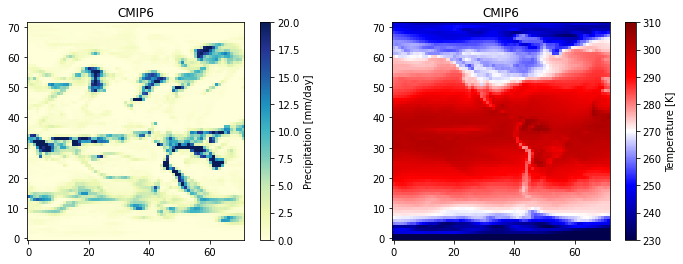

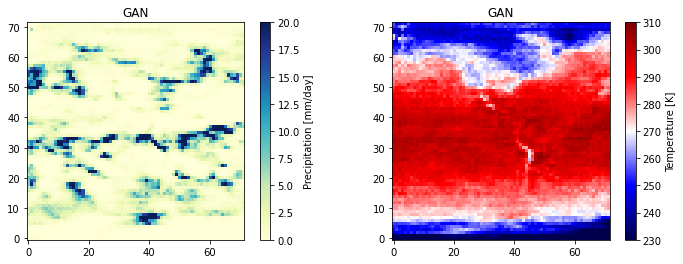

In [77]:
i = np.random.randint(100)
print(i)
plot_sample(target[i].cpu(), title='CMIP6')
plot_sample(gan[i].cpu(), title='GAN')

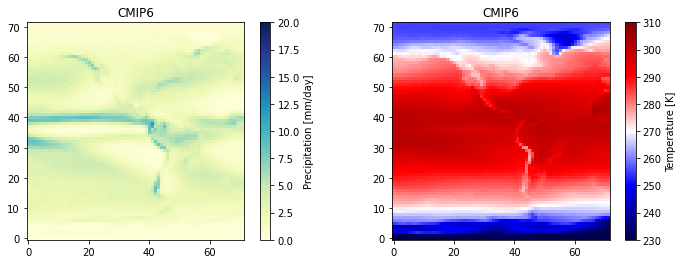

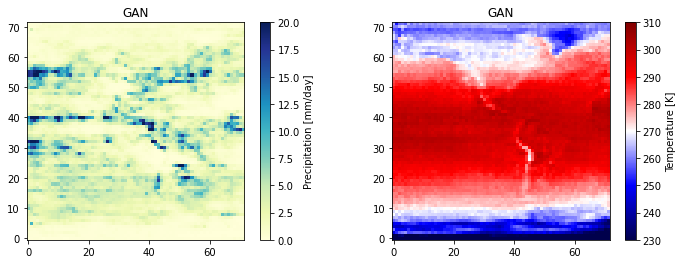

In [78]:
target_mean = target.mean(dim=0)
gan_mean = gan.mean(dim=0)
plot_sample(target_mean.cpu(), title='CMIP6')
plot_sample(gan_mean.cpu(), title='GAN')
    

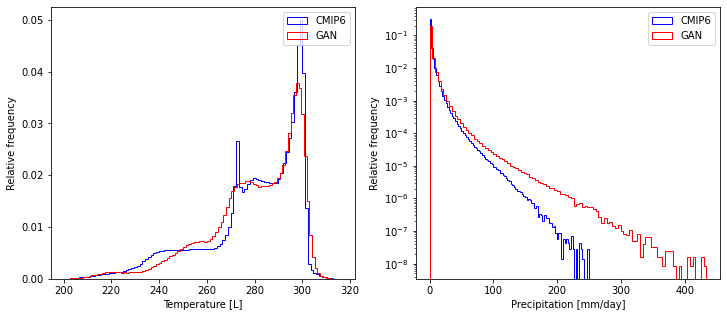

In [120]:

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)

plt.hist(target[:,1].cpu().numpy().flatten(),
         histtype='step',
         density=True,
         bins=100,
         label='CMIP6',
         color='blue')

plt.hist(gan[:,1].cpu().numpy().flatten(),
         histtype='step',
         density=True,
         bins=100,
         label='GAN',
         color='red')  

plt.ylabel('Relative frequency')
plt.xlabel('Temperature [L]')
plt.legend()

plt.subplot(1,2,2)
plt.hist((target[:,0]*24*3600).cpu().numpy().flatten(), 
         histtype='step',
         density=True,
         log=True,
         bins=100,
         label='CMIP6',
         color='blue')
         
         

plt.hist((gan[:,0]*24*3600).cpu().numpy().flatten(),
         histtype='step',
         density=True,
         log=True,
         bins=100,
         label='GAN',
         color='red')

plt.ylabel('Relative frequency')
plt.xlabel('Precipitation [mm/day]')
plt.legend()
plt.show()